In [1]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.manifold import TSNE

In [2]:
os.chdir('..')

In [3]:
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )

from analysis.auto_report import AutoSummaryReport

In [4]:
def get_metrics(root_dir: str) -> pd.DataFrame:
    metrics = pd.DataFrame()

    metrics_files = root_dir.rglob("metrics.csv")
    for metric_file in metrics_files:
        data_name = metric_file.parent.parent.stem

        metric_summary = pd.read_csv(metric_file)
        metric_summary["data_name"] = data_name

        metrics = pd.concat([metrics, metric_summary])

    return metrics

path = 'report/2024-09-17_19-01-25'
metrics = get_metrics(Path(path))

In [5]:
acc_b = metrics[metrics['metric'] == 'acc']
acc_b = acc_b[acc_b['data'] == 'test']

baseline = acc_b[acc_b['type'] == 'static']
our_results = acc_b[acc_b['type'] == 'dynamic']

In [6]:
acc_b['rank'] = acc_b.groupby("data_name")["score"].rank(method="average", ascending=False)
# acc_b = acc_b[acc_b['rank'] != 1.5]
avg_ranks = acc_b.groupby('type')['rank'].mean()

# CD plots

In [7]:
avg_ranks.index = ['our approach', 'AutoGluon']
avg_ranks

our approach    1.457143
AutoGluon       1.542857
Name: rank, dtype: float64

0.2780310713014439


/tmp/ipykernel_20305/2948809395.py:4: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = scoring.compute_CD(avranks, datasets_n, alpha="0.1")
/tmp/ipykernel_20305/2948809395.py:6: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)


Text(0.5, 1.0, 'Critical Distance - comparison of our approach and AutoGluon')

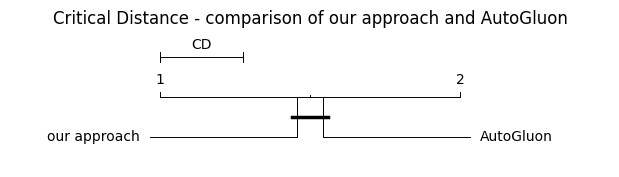

In [8]:
names = avg_ranks.index.tolist()
avranks =  avg_ranks.values.tolist()
datasets_n = np.unique(acc_b['data_name']).shape[0]
cd = scoring.compute_CD(avranks, datasets_n, alpha="0.1")
print(cd)
scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)
plt.title('Critical Distance - comparison of our approach and AutoGluon')


# Gain comparison

# Best method vs AutoGluon

In [9]:
comp = pd.merge(our_results, baseline, on='data_name')
comp['diff'] = comp['score_x'] - comp['score_y']
comp = comp[comp['diff'] != 0] 


colors = []
for name in names:
    if 'static' in name:
        color = '#D4E09B'
    elif 'liltab' in name:
        color = '#A44A3F'
    else:
        color = '#F19C79'
    colors.append(color)

/tmp/ipykernel_20305/2673273363.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(data=comp, y='diff', showmeans=True, meanline=True, palette=colors, showfliers=False)
/tmp/ipykernel_20305/2673273363.py:3: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  g = sns.boxplot(data=comp, y='diff', showmeans=True, meanline=True, palette=colors, showfliers=False)


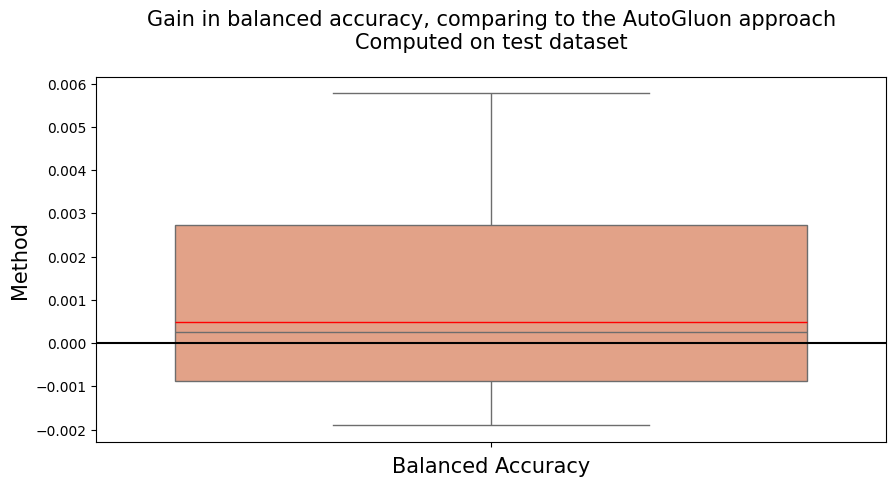

In [10]:
plt.figure(figsize=(9, 4))

g = sns.boxplot(data=comp, y='diff', showmeans=True, meanline=True, palette=colors, showfliers=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.axhline(0, color='black')
plt.xlabel('Balanced Accuracy', fontsize=15)
plt.ylabel('Method', fontsize=15)
plt.title('Gain in balanced accuracy, comparing to the AutoGluon approach\nComputed on test dataset', fontsize=15, pad=20)

ax = plt.gca()
mean_lines = [line for line in ax.lines if line.get_linestyle() == '--']

for i in range(len(mean_lines)):
    mean_lines[i].set_color('red')
    mean_lines[i].set_linestyle('-')

plt.show()